In [110]:
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import html
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding,Concatenate,Input,Bidirectional,LSTM,Dense,Dropout,GlobalAveragePooling1D,LayerNormalization,Layer
from tensorflow.keras.metrics import F1Score
from sklearn.model_selection import train_test_split
from itertools import chain

In [99]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
speller = Speller(lang='en')

url_pattern = r'https?://\S+|www\.\S+|'
mention_pattern = r'@\w+'
html_tags_pattern = r'<.*?>'
special_chars_pattern = r'[^a-zA-Z\s]'

In [100]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [117]:
def clean_text(text):
    text = html.unescape(text)
    text = text.lower()
    text = re.sub(url_pattern, '', text)
    text = re.sub(mention_pattern, '', text)
    text = re.sub(html_tags_pattern, '', text)
    text = re.sub(special_chars_pattern, '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def preprocess_text(text):
    if pd.isna(text) or not isinstance(text, str):
        return ""
    text = clean_text(text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [speller(word) for word in tokens]
    tokens = [lemmatizer.lemmatize(word,pos='v') for word in tokens]
    text = ' '.join(tokens)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

def preprocess_text_series(series: pd.Series) -> pd.Series:
    return series.progress_apply(preprocess_text)

In [113]:
print(len(train_data))
print(train_data.isna().sum())

7613
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


Text(0.5, 1.0, 'WordCloud')

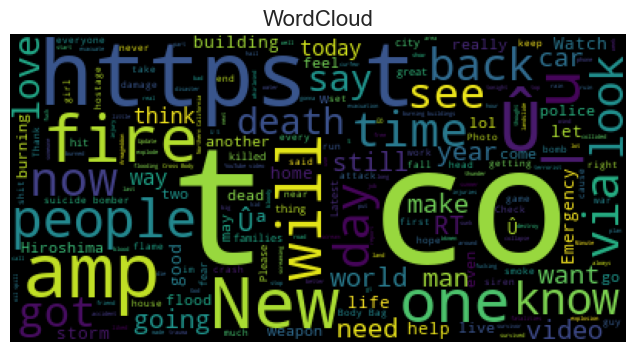

In [121]:
sns.set(rc={'figure.figsize': (8, 4)})
plt.imshow(WordCloud().generate(' '.join(train_data['text'].tolist())))
plt.axis('off')
plt.title('WordCloud', fontsize=16)

In [122]:
processed_texts = []
for text in train_data['text']:
    processed_texts.append(preprocess_text(text))
train_data['Processed Text'] = processed_texts
train_data.head()

In [29]:
train_data['text'] = train_data['text'].astype(str).str.replace(r'Ã[\x80-\xBF]+|[^a-zA-Z\s]|\s+', ' ', regex=True).str.strip().str.lower()
test_data['text'] = test_data['text'].astype(str).str.replace(r'Ã[\x80-\xBF]+|[^a-zA-Z\s]|\s+', ' ', regex=True).str.strip().str.lower()
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake m...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are ...,1
3,6,NaN,NaN,people receive wildfires evacuation orders in...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as ...,1


In [30]:
tokenized_text = []
for text in train_data['text']:
    tokens = word_tokenize(text)
    tokenized_text.append(tokens)
train_data['Text Tokenized'] = tokenized_text

tokenized_text = []
for text in test_data['text']:
    tokens = word_tokenize(text)
    tokenized_text.append(tokens)
test_data['Text Tokenized'] = tokenized_text

train_data.head()

,id,keyword,location,text,target,Text Tokenized
0,1,NaN,NaN,our deeds are the reason of this earthquake m...,1,"[our, deeds, are, the, reason, of, this, earth..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,all residents asked to shelter in place are ...,1,"[all, residents, asked, to, shelter, in, place..."
3,6,NaN,NaN,people receive wildfires evacuation orders in...,1,"[people, receive, wildfires, evacuation, order..."
4,7,NaN,NaN,just got sent this photo from ruby alaska as ...,1,"[just, got, sent, this, photo, from, ruby, ala..."


In [31]:
stop_words = stopwords.words('english')

text_no_stopwords = []
for text in train_data['Text Tokenized']:
    text_no_stopwords1 = [word for word in text if word not in stop_words]
    text_no_stopwords.append(text_no_stopwords1)
train_data['Text Without Stopwords'] = text_no_stopwords

text_no_stopwords = []
for text in test_data['Text Tokenized']:
    text_no_stopwords1 = [word for word in text if word not in stop_words]
    text_no_stopwords.append(text_no_stopwords1)
test_data['Text Without Stopwords'] = text_no_stopwords

train_data.head()

,id,keyword,location,text,target,Text Tokenized,Text Without Stopwords
0,1,NaN,NaN,our deeds are the reason of this earthquake m...,1,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,all residents asked to shelter in place are ...,1,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,people receive wildfires evacuation orders in...,1,"[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order..."
4,7,NaN,NaN,just got sent this photo from ruby alaska as ...,1,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi..."


In [32]:
lemmatizer = WordNetLemmatizer()

lemmatized_text = []
for text in train_data['Text Without Stopwords']:
    lemmatized_text1 = [lemmatizer.lemmatize(word,pos='v') for word in text]
    lemmatized_text.append(lemmatized_text1)
train_data['Text Lemmatized'] = lemmatized_text

lemmatized_text = []
for text in test_data['Text Without Stopwords']:
    lemmatized_text1 = [lemmatizer.lemmatize(word,pos='v') for word in text]
    lemmatized_text.append(lemmatized_text1)
test_data['Text Lemmatized'] = lemmatized_text

train_data.head()

,id,keyword,location,text,target,Text Tokenized,Text Without Stopwords,Text Lemmatized
0,1,NaN,NaN,our deeds are the reason of this earthquake m...,1,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,all residents asked to shelter in place are ...,1,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[residents, ask, shelter, place, notify, offic..."
3,6,NaN,NaN,people receive wildfires evacuation orders in...,1,"[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order..."
4,7,NaN,NaN,just got sent this photo from ruby alaska as ...,1,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[get, send, photo, ruby, alaska, smoke, wildfi..."


In [33]:
processed_text = []
for text in train_data['Text Lemmatized']:
    text = ' '.join(text)
    processed_text.append(text)
train_data['Processed Text'] = processed_text

processed_text = []
for text in test_data['Text Lemmatized']:
    text = ' '.join(text)
    processed_text.append(text)
test_data['Processed Text'] = processed_text

train_data.head()

,id,keyword,location,text,target,Text Tokenized,Text Without Stopwords,Text Lemmatized,Processed Text
0,1,NaN,NaN,our deeds are the reason of this earthquake m...,1,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[deeds, reason, earthquake, may, allah, forgiv...",deeds reason earthquake may allah forgive us
1,4,NaN,NaN,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,NaN,all residents asked to shelter in place are ...,1,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[residents, ask, shelter, place, notify, offic...",residents ask shelter place notify officer eva...
3,6,NaN,NaN,people receive wildfires evacuation orders in...,1,"[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order...",people receive wildfires evacuation order cali...
4,7,NaN,NaN,just got sent this photo from ruby alaska as ...,1,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[get, send, photo, ruby, alaska, smoke, wildfi...",get send photo ruby alaska smoke wildfires pou...


In [36]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['Processed Text'])
vocab_size = len(tokenizer.word_index) + 1
vocab_size

20078

In [37]:
train_sequences = tokenizer.texts_to_sequences(train_data['Processed Text'])
test_sequences = tokenizer.texts_to_sequences(test_data['Processed Text'])

train_sequences = np.array(pad_sequences(train_sequences, padding='post'))
test_sequences = np.array(pad_sequences(test_sequences, padding='post', maxlen=train_sequences.shape[1]))

In [38]:
print(train_sequences.shape, test_sequences.shape)

(7613, 27) (3263, 27)


In [39]:
x_train, x_val, y_train, y_val = train_test_split(train_sequences, train_data['target'], test_size=0.2)

In [84]:
model = Sequential([
    Embedding(len(tokenizer.word_index)+1, 64),
    Bidirectional(LSTM(64,return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(16)),
    Dense(1, activation='sigmoid')
])

model.compile(loss="binary_crossentropy",optimizer='adam',metrics=[F1Score(threshold = 0.5)])

In [85]:
reduce_lr = ReduceLROnPlateau(monitor='val_f1_score', factor=0.2, patience=4, verbose=1, min_lr=0.0001)

history=model.fit(x_train,y_train,epochs=20,validation_data=(x_val,y_val),verbose=1,callbacks=[reduce_lr])

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - f1_score: 0.4387 - loss: 0.5968 - val_f1_score: 0.7281 - val_loss: 0.4477 - learning_rate: 0.0010
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - f1_score: 0.8764 - loss: 0.2650 - val_f1_score: 0.6885 - val_loss: 0.6432 - learning_rate: 0.0010
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - f1_score: 0.9535 - loss: 0.1217 - val_f1_score: 0.7079 - val_loss: 0.5889 - learning_rate: 0.0010
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - f1_score: 0.9805 - loss: 0.0653 - val_f1_score: 0.7097 - val_loss: 0.7323 - learning_rate: 0.0010
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - f1_score: 0.9838 - loss: 0.0512 - val_f1_score: 0.7114 - val_loss: 0.7748 - learning_rate: 0.0010
Epoch 6/20
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - f1_score: 0.9911 - loss: 0.0350
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - f1_score: 0.9911 - loss: 0.

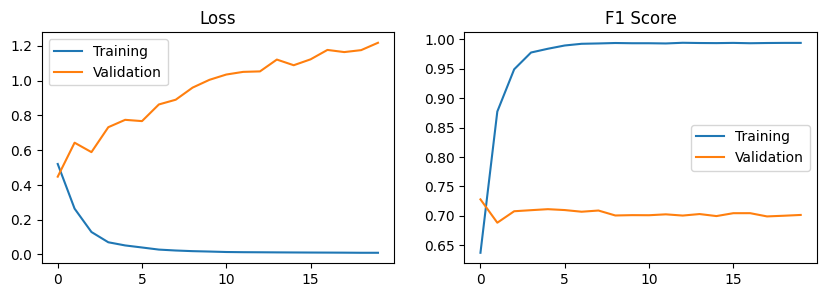

In [86]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('F1 Score')
plt.plot(history.history['f1_score'], label='Training')
plt.plot(history.history['val_f1_score'], label='Validation')
plt.legend()

191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Text(0.5, 1.0, 'Training Data F1 Score: 1.0')

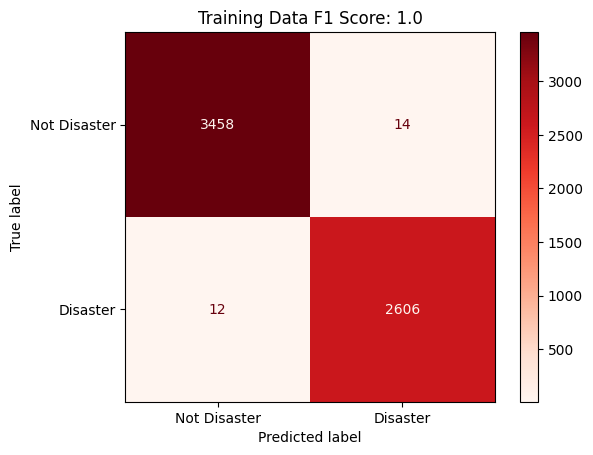

In [87]:
y_train_pred = model.predict(x_train)
y_train_pred = [int(p.item()>=0.5) for p in y_train_pred]
conf_matrix = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=['Not Disaster','Disaster'],cmap=plt.cm.Reds)
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
f1_score = tp / (tp+((fn+fp)/2))
conf_matrix.ax_.set_title('Training Data F1 Score: '+str(f1_score.round(2)))

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Text(0.5, 1.0, 'Validation Data F1 Score: 0.7')

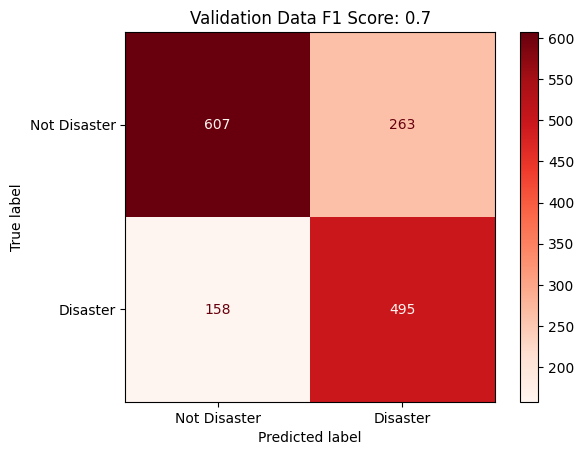

In [88]:
y_val_pred = model.predict(x_val)
y_val_pred = [int(p.item()>=0.5) for p in y_val_pred]
conf_matrix = ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, display_labels=['Not Disaster','Disaster'],cmap=plt.cm.Reds)
tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
f1_score = tp / (tp+((fn+fp)/2))
conf_matrix.ax_.set_title('Validation Data F1 Score: '+str(f1_score.round(2)))

In [89]:
pred = model.predict(test_sequences)
y_pred = [(1 if p>=0.5 else 0) for p in pred]

submission = pd.DataFrame({'id':test_data['id'], 'target':y_pred})
submission.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [34]:
class TransformerBlock(Layer):
    def __init__(self, d_model, num_heads, dropout_rate=0.2):
        super().__init__()
        self.attn = tf.keras.layers.MultiHeadAttention(num_heads, d_model)
        self.ffn = tf.keras.Sequential([
            Dense(d_model * 2, activation='relu'),
            Dropout(dropout_rate),
            Dense(d_model)
        ])
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, inputs):
        attn_output = self.attn(inputs, inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.norm2(out1 + ffn_output)
        return out2

def transformer_classifier(vocab_size, max_len, d_model, num_layers, num_heads, num_classes):
    input_ids = Input(shape=(max_len,))
    token_embeddings = Embedding(vocab_size, d_model)(input_ids)
    x = token_embeddings
    for _ in range(num_layers):
        x = TransformerBlock(d_model, num_heads)(x)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_ids, outputs=outputs)
    return model

model1 = transformer_classifier(vocab_size=len(text_tokenizer.word_index)+1, max_len=33, d_model=64, num_layers=2, num_heads=8, num_classes=1)
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=[F1Score(threshold = 0.5)])

In [35]:
reduce_lr = ReduceLROnPlateau(monitor='val_f1_score', factor=0.2, patience=10, verbose=1, min_lr=0.0001)
history1=model1.fit(x_train,y_train,epochs=50,validation_data=(x_val,y_val),verbose=1,callbacks=[reduce_lr])

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - f1_score: 0.5002 - loss: 0.6536 - val_f1_score: 0.7589 - val_loss: 0.4723 - learning_rate: 0.0010
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - f1_score: 0.8817 - loss: 0.2592 - val_f1_score: 0.7238 - val_loss: 0.5640 - learning_rate: 0.0010
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - f1_score: 0.9650 - loss: 0.0956 - val_f1_score: 0.7070 - val_loss: 0.7030 - learning_rate: 0.0010
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - f1_score: 0.9831 - loss: 0.0464 - val_f1_score: 0.7072 - val_loss: 1.0201 - learning_rate: 0.0010
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - f1_score: 0.9892 - loss: 0.0323 - val_f1_score: 0.6968 - val_loss: 0.9366 - learning_rate: 0.0010
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - f1_score: 0.9932 - loss: 0.0201 - val_f1_score: 0.6693 - val_loss: 1.0923 - learning_rate: 0.0010
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - f1_score: 0.9943 - loss: 0

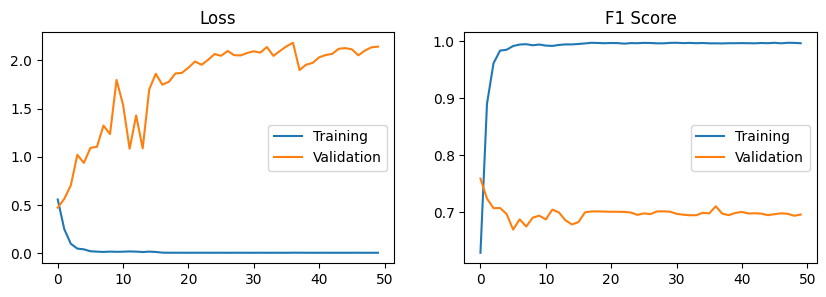

In [36]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history1.history['loss'], label='Training')
plt.plot(history1.history['val_loss'], label='Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('F1 Score')
plt.plot(history1.history['f1_score'], label='Training')
plt.plot(history1.history['val_f1_score'], label='Validation')
plt.legend()

191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


Text(0.5, 1.0, 'Training Data F1 Score: 1.0')

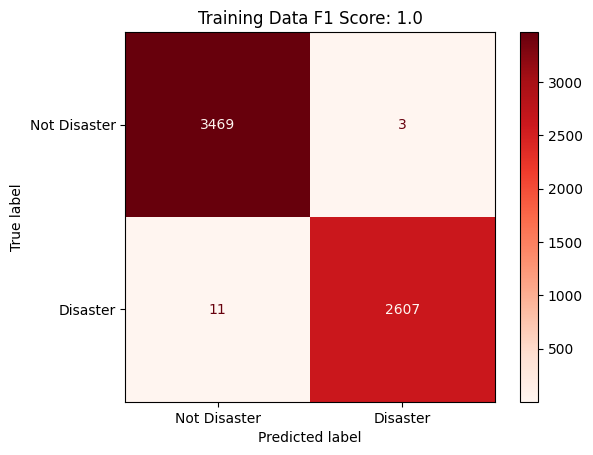

In [37]:
y_train_pred = model1.predict(x_train)
y_train_pred = [int(p.item()>=0.5) for p in y_train_pred]
conf_matrix = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=['Not Disaster','Disaster'],cmap=plt.cm.Reds)
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
f1_score = tp / (tp+((fn+fp)/2))
conf_matrix.ax_.set_title('Training Data F1 Score: '+str(f1_score.round(2)))

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


Text(0.5, 1.0, 'Validation Data F1 Score: 0.7')

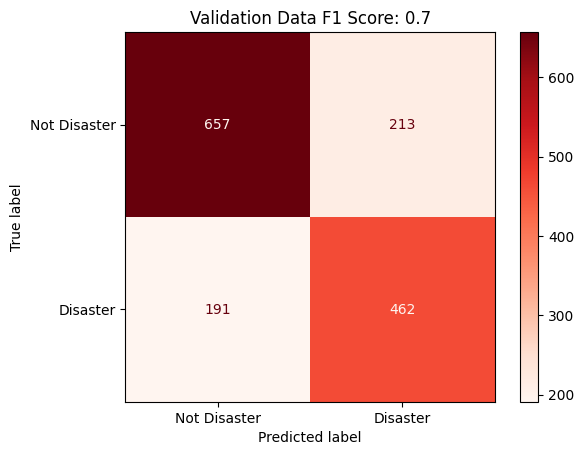

In [38]:
y_val_pred = model1.predict(x_val)
y_val_pred = [int(p.item()>=0.5) for p in y_val_pred]
conf_matrix = ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, display_labels=['Not Disaster','Disaster'],cmap=plt.cm.Reds)
tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
f1_score = tp / (tp+((fn+fp)/2))
conf_matrix.ax_.set_title('Validation Data F1 Score: '+str(f1_score.round(2)))

In [39]:
pred = model1.predict(test_sequences)
y_pred = [(1 if p>=0.5 else 0) for p in pred]

submission = pd.DataFrame({'id':test_data['id'], 'target':y_pred})
submission.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
